In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *
#from fastai.transforms import *
from fastai.conv_learner import *
#from fastai.model import *
#from fastai.dataset import *
#from fastai.sgdr import *
#from fastai.plots import *

In [3]:
print(torch.__version__)

0.4.0


In [4]:
PATH = "./"

In [6]:
import pydicom
import glob
import os
import numpy
import seaborn as sns
from itertools import chain

In [6]:
lstFilesDCM = []  # create an empty list
'''for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))'''

'for dirName, subdirList, fileList in os.walk(PathDicom):\n    for filename in fileList:\n        if ".dcm" in filename.lower():  # check whether the file\'s DICOM\n            lstFilesDCM.append(os.path.join(dirName,filename))'

In [7]:
df1to4 = pd.read_csv('comandfile.csv')

In [8]:
df1to4 = df1to4[~df1to4.Group.str.contains('Control')]

In [9]:
df1to4 = df1to4[~df1to4.TOTAL3.isnull()]

In [10]:
df1to4.any().isnull()

Image Data ID    False
Group            False
Subject          False
Age              False
Sex              False
Filenames        False
TOTAL3           False
1YR              False
2YR              False
3YR              False
TOTAL3.1         False
dtype: bool

In [11]:
df1to4.loc[df1to4['Sex']=='F', 'Sex']=0
df1to4.loc[df1to4['Sex']=='M', 'Sex']=1

In [12]:
pro = (df1to4['1YR'].values - df1to4['TOTAL3'].values)
progress = []

for i in pro:
    if i > 2 : progress.append(-1)
    elif i < (-2) : progress.append(1)
    else : progress.append(0)
df1to4['Progress'] = progress
del(pro,progress)

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scale3 = MinMaxScaler()

In [15]:
print(scale3.fit(df1to4['TOTAL3'].values.reshape(-1,1)))

MinMaxScaler(copy=True, feature_range=(0, 1))


In [16]:
df1to4['3scale'] = scale3.transform(df1to4['TOTAL3'].values.reshape(-1,1))

In [15]:
from sklearn.model_selection import train_test_split
X_train_tmp, X_test_tmp, param_train_tmp, param_test_tmp, y_train_tmp, y_test_tmp = train_test_split(df1to4, df1to4[['Sex','Age','TOTAL3']], df1to4['1YR'], test_size=0.2)

from sklearn.model_selection import train_test_split
X_train_tmp, X_val_tmp, param_train_tmp, param_val_tmp, y_train_tmp, y_val_tmp = train_test_split(X_train_tmp, param_train_tmp, y_train_tmp, test_size=0.3)

In [16]:
lstFilesDCM_train = []  # create an empty list
lstFilesDCM_test = []
lstFilesDCM_val = []
lstFilesDCM_train = X_train_tmp['Filenames'].values
lstFilesDCM_train = lstFilesDCM_train.tolist()
lstFilesDCM_test = X_test_tmp['Filenames'].values
lstFilesDCM_test = lstFilesDCM_test.tolist()
lstFilesDCM_val = X_val_tmp['Filenames'].values
lstFilesDCM_val = lstFilesDCM_val.tolist()

For NORMAL Image

In [17]:
#Training Set

In [18]:
# loop through all the DICOM files
image_array_train =[]

for filenameDCM in lstFilesDCM_train:
    ds = pydicom.read_file(filenameDCM)
    ds_3d = ds.pixel_array[30]
    for i in range(31,51):
        ds_3d = np.dstack((ds_3d,ds.pixel_array[i]))

    image_array_train.append(ds_3d)

image_array_train = np.asarray(image_array_train)
image_array_train = image_array_train.transpose(0,3,1,2)
image_array_train.shape

(685, 21, 109, 91)

In [19]:
image_array_train= image_array_train.astype('float64')

In [20]:
image_array_train -= image_array_train.min()
image_array_train /= (image_array_train.max()-image_array_train.min())

In [21]:
image_array_train.shape

(685, 21, 109, 91)

In [22]:
#Validation set

In [23]:
# loop through all the DICOM files
image_array_val =[]

for filenameDCM in lstFilesDCM_val:
    ds = pydicom.read_file(filenameDCM)
    ds_3d = ds.pixel_array[30]
    for i in range(31,51):
        ds_3d = np.dstack((ds_3d,ds.pixel_array[i]))

    image_array_val.append(ds_3d)

image_array_val = np.asarray(image_array_val, dtype='float64')
image_array_val = image_array_val.transpose(0,3,1,2)
image_array_val -= image_array_val.min()
image_array_val /= (image_array_val.max()-image_array_val.min())
image_array_val.shape

(294, 21, 109, 91)

In [24]:
#Test set

In [25]:
# loop through all the DICOM files
image_array_test =[]

for filenameDCM in lstFilesDCM_test:
    ds = pydicom.read_file(filenameDCM)
    ds_3d = ds.pixel_array[30]
    for i in range(31,51):
        ds_3d = np.dstack((ds_3d,ds.pixel_array[i]))

    image_array_test.append(ds_3d)

image_array_test = np.asarray(image_array_test, dtype='float64')
image_array_test = image_array_test.transpose(0,3,1,2)
image_array_test -= image_array_test.min()
image_array_test /= (image_array_test.max()-image_array_test.min())
image_array_test.shape 

(245, 21, 109, 91)

In [26]:
y_train = y_train_tmp.values
#y_train = np.hstack((y_train,y_train,y_train))
#y_train = np.hstack((y_train,y_train))
y_val = y_val_tmp.values
#y_val= np.hstack((y_val,y_val,y_val))
y_test = y_test_tmp.values
#y_val= np.hstack((y_val,y_val,y_val))

In [27]:
y_train.shape,y_val.shape,y_test.shape

((685,), (294,), (245,))

In [28]:
param_train = param_train_tmp.values
params = []
for i in param_train:
    stack = []
    stack.append(i)
    stack = stack*10
    params.append(stack)
param_train = np.asarray(params)
del(params)

In [29]:
param_val = param_val_tmp.values
params = []
for i in param_val:
    stack = []
    stack.append(i)
    stack = stack*10
    params.append(stack)
param_val = np.asarray(params)
del(params)

param_test = param_test_tmp.values
params = []
for i in param_test:
    stack = []
    stack.append(i)
    stack = stack*10
    params.append(stack)
param_test = np.asarray(params)
del(params)

In [30]:
#x6 Param match training Image
#param_train = np.vstack((param_train,param_train,param_train))
#param_train = np.vstack((param_train,param_train))

In [31]:
param_train.shape

(685, 10, 3)

### Load dataset

In [32]:
X_train = torch.utils.data.DataLoader(image_array_train, batch_size=4)
param_train = torch.utils.data.DataLoader(param_train, batch_size=4)
y_train = torch.utils.data.DataLoader(y_train, batch_size=4)
X_val = torch.utils.data.DataLoader(image_array_val, batch_size=4)
param_val = torch.utils.data.DataLoader(param_val, batch_size=4)
y_val = torch.utils.data.DataLoader(y_val, batch_size=4)
X_test = torch.utils.data.DataLoader(image_array_test, batch_size=4)
param_test = torch.utils.data.DataLoader(param_test, batch_size=4)
y_test = torch.utils.data.DataLoader(y_test, batch_size=4)

del(image_array_train,image_array_val,image_array_test)
del(X_train_tmp,X_val_tmp,X_test_tmp,y_train_tmp,y_val_tmp,y_test_tmp,param_train_tmp,param_val_tmp,param_test_tmp)

### Darknet

In [33]:
def conv_layer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv3d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm3d(nf, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1, inplace=False))

class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1=conv_layer(ni, ni//2, ks=1)
        self.conv2=conv_layer(ni//2, ni, ks=3)
        
    def forward(self, x): return x.add_(self.conv2(self.conv1(x.clone())))

class Darknet(nn.Module):
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        return [conv_layer(ch_in, ch_in*2,stride=stride)
               ] + [(ResLayer(ch_in*2)) for i in range(num_blocks)]

    def __init__(self, num_blocks, num_classes, nf=32):
        super().__init__()
        features = [conv_layer(1, nf, ks=3, stride=1)]
        for i,nb in enumerate(num_blocks):
            features += self.make_group_layer(nf, nb, stride=2-(i==1))
            nf *= 2                        
        features += [nn.AdaptiveAvgPool3d((2,4,4)), Flatten()]        
        self.features = nn.Sequential(*features)
        fc1 = [nn.Linear(32798, 320), nn.LeakyReLU(negative_slope=0.1, inplace=False)]
        self.fc1 = nn.Sequential(*fc1)
        self.layers = nn.Sequential(nn.Linear(320,1))
        
    def forward(self, x, y):
        x = x.unsqueeze(1)
        x1 = self.features(x)
        x = torch.cat((x1,y[:,:,0],y[:,:,1],y[:,:,2]),1)
        x = self.fc1(x)
        #x = F.dropout(x, p=0.2, training=self.training)        
        return self.layers(x)


In [34]:
m = Darknet([1,2,4,6,3], num_classes=1, nf=32)
m.double()
#m = nn.DataParallel(m, [1,2,3])

Darknet(
  (features): Sequential(
    (0): Sequential(
      (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (2): ResLayer(
      (conv1): Sequential(
        (0): Conv3d(64, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
      (conv2): Sequential(
        (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
m.to(device)
print(device)

cuda:0


In [48]:
optimizer = optim.Adam(m.parameters(),lr=0.0001)
criterion = nn.MSELoss().cuda()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)

### Train

In [41]:
losslog=[]
vallog=[]

In [42]:
def train(niter):
    for epoch in trange(niter):  # loop over the dataset multiple times
        running_loss = 0.0        

        m.train(True)
        scheduler.step()
        with tqdm(total=len(X_train)) as pbar:
            for i, (x, p, y) in enumerate(zip(X_train,param_train,y_train)):
                x,p,y = x.to(device), p.to(device),y.to(device)

                i += 1
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = m(Variable(x),Variable(p))
                loss = criterion(outputs,Variable(y).unsqueeze(1))
                loss.backward()
                for param in optimizer.param_groups[0]['params']:
                    param.data = param.data.add(-0.0001 * optimizer.param_groups[0]['lr'], param.data)
                optimizer.step()

                pbar.update()

                # print statistics
                running_loss += loss.item()
                if i % 20 == 19:    # print every 20 mini-batches
                    print('[%d, %5d]  Train MSE loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 20))
                    losslog.append(running_loss/20)
                    running_loss = 0.0
                    
            #Eval
        with tqdm(total=len(X_val)) as pbar:
            with torch.no_grad():
                predicted =[]
                for i, ( x, p, y) in enumerate(zip(X_val,param_val,y_val)):
                    x,p,y = x.to(device), p.to(device),y.to(device)

                    # forward + backward + optimize
                    outputs = m(x,p)
                    pred = outputs.squeeze(1).cpu().numpy().tolist()
                    predicted.append(pred)
                    pbar.update()

                predicted = list(chain.from_iterable(predicted))
                valloss = ((predicted-y_val.dataset) **2).mean()
                #valloss = abs(predicted-y_val.dataset).sum()/len(y_val.dataset)
                vallog.append(valloss)
                print(f'Val MSE loss: {valloss}')
            
    print('Finished Training')
    return losslog,vallog

In [49]:
TT = train(1)

100%|██████████| 74/74 [08:59<00:00,  6.34s/it]Val MSE loss: 43.91249017749332

100%|██████████| 1/1 [1:14:24<00:00, 4464.88s/it]Finished Training


In [50]:
optimizer = optim.Adam(m.parameters(),lr=0.00005)
criterion = nn.MSELoss().cuda()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)
TT = train(1)

100%|██████████| 74/74 [08:59<00:00,  6.34s/it]Val MSE loss: 43.40522154895921

100%|██████████| 1/1 [1:14:22<00:00, 4462.44s/it]Finished Training


In [51]:
vallog

[44.71909202365689,
 43.41934559492262,
 86.89565591193487,
 43.91249017749332,
 43.40522154895921]

## Validate

In [45]:
def test():
    with torch.no_grad():
        n = len(X_test)
        m.eval()
        predicted = []
        with tqdm(total=n) as pbar:
            for i, ( x, p, y) in enumerate(zip(X_test,param_test,y_test)):
                x,p,y = x.to(device), p.to(device),y.to(device)


                # forward + backward + optimize
                outputs = m(x,p)
                pred = outputs.squeeze(1).cpu().numpy().tolist()
                predicted.append(pred)
                pbar.update()
                
        predicted = list(chain.from_iterable(predicted))
        loss = ((predicted - y_test.dataset)**2).mean()
        #loss = abs(predicted-y_test.dataset).sum()/len(y_test.dataset)
        print(f'MSE loss: {loss}')
        df_y = pd.DataFrame(y_test.dataset,columns=['actual'])
        df_pred = pd.DataFrame(predicted,columns=['predicted'])
        df_pred = df_pred.join(df_y)
        sns.jointplot(x=df_pred['actual'], y=df_pred['predicted'])
        sns.distplot(y_test.dataset)
        sns.distplot(df_pred['predicted'])
    return df_pred, loss

100%|██████████| 62/62 [07:26<00:00,  5.78s/it]
MSE loss: 77.20365117126697


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is

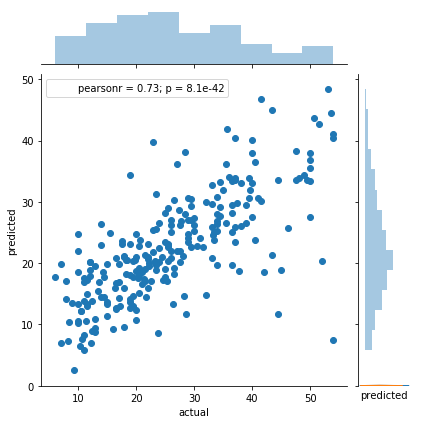

In [46]:
TEST = test()

In [47]:
TEST

(     predicted     actual
 0    30.595904  39.500000
 1    40.093737  40.000000
 2    33.820889  48.000000
 3    21.045233  22.000000
 4    43.756438  50.666667
 5    23.039069  25.500000
 6    21.854479  23.000000
 7    26.199561  26.000000
 8    20.506390  18.250000
 9    17.802042  14.500000
 10   23.087421  17.500000
 11   21.062244  18.000000
 12   20.290602  52.000000
 13   35.491884  50.000000
 14   22.818892  20.500000
 15   15.994589  18.000000
 16   19.622336  23.500000
 17   22.561314  31.500000
 18   15.949152  22.000000
 19   29.459995  36.500000
 20    8.544378  23.750000
 21   13.369613  11.500000
 22   23.196722  19.000000
 23   10.874419  13.000000
 24   19.903857  17.000000
 25   17.039360  25.333333
 26   27.607287  40.000000
 27   41.061983  54.000000
 28   20.144615  23.333333
 29   11.432175  15.000000
 ..         ...        ...
 215  20.809374  33.000000
 216  42.739659  51.500000
 217  36.238772  27.000000
 218  19.173455  26.500000
 219  26.505511  35.500000
 

In [46]:
model_save_path = './save_model/'

In [61]:
torch.save(m.state_dict(),'Age_Sex_TOTAL3_3D.pth')

In [43]:
m = Darknet([1,2,4,6,3], num_classes=1, nf=32)
m.double()
m.load_state_dict(torch.load('Age_Sex_TOTAL3_3D.pth'))

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
m.to(device)
print(device)

cuda:0


In [42]:
sns.pairplot

<function seaborn.axisgrid.pairplot(data, hue=None, hue_order=None, palette=None, vars=None, x_vars=None, y_vars=None, kind='scatter', diag_kind='hist', markers=None, size=2.5, aspect=1, dropna=True, plot_kws=None, diag_kws=None, grid_kws=None)>

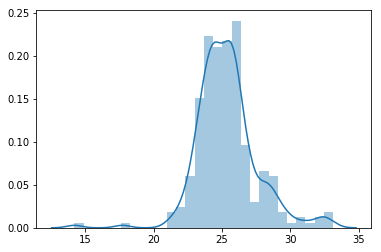

In [117]:
sns.distplot(y_pred)

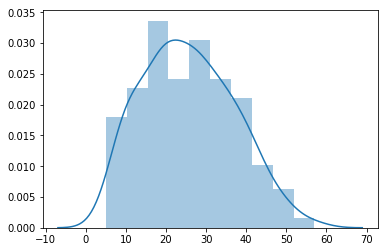

In [118]:
sns.distplot(y_test)

## MultiLabel

In [56]:
def conv_layer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1, inplace=False))

class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1=conv_layer(ni, ni//2, ks=1)
        self.conv2=conv_layer(ni//2, ni, ks=3)
        
    def forward(self, x): return x.add_(self.conv2(self.conv1(x.clone())))

class Darknet(nn.Module):
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        return [conv_layer(ch_in, ch_in*2,stride=stride)
               ] + [(ResLayer(ch_in*2)) for i in range(num_blocks)]

    def __init__(self, num_blocks, num_classes, nf=32):
        super().__init__()
        features = [conv_layer(1, nf, ks=3, stride=1)]
        for i,nb in enumerate(num_blocks):
            features += self.make_group_layer(nf, nb, stride=2-(i==1))
            nf *= 2                        
        features += [nn.AdaptiveAvgPool2d(1), Flatten()]        
        self.features = nn.Sequential(*features)
        fc1 = [nn.Linear(1054, 120), nn.BatchNorm1d(120, momentum=0.01), nn.LeakyReLU(negative_slope=0.1, inplace=False)]
        self.fc1 = nn.Sequential(*fc1)
        self.layers = nn.Sequential(nn.Linear(120,num_classes))
        
    def forward(self, x, y):
        x = x.unsqueeze(1)
        x1 = self.features(x)
        x = torch.cat((x1,y[:,:,0],y[:,:,1],y[:,:,2]),1)
        x = self.fc1(x)
        x = F.relu(x)
        #x = F.dropout(x, p=0.2, training=self.training)
        return F.log_softmax(self.layers(x), dim=-1)

In [57]:
ml = Darknet([1,2,4,6,3], num_classes=3, nf=32)
ml.double()
#m = nn.DataParallel(m, [1,2,3])

Darknet(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (2): ResLayer(
      (conv1): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
      (conv2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_st

In [60]:
optimizer = optim.RMSprop(ml.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
ml.to(device)
print(device)

### Train

losslog=[]
vallog=[]

def train(niter):
    for epoch in trange(niter):  # loop over the dataset multiple times
        running_loss = 0.0        

        ml.train(True)
        scheduler.step()
        with tqdm(total=len(X_train)) as pbar:
            for i, (x, p, y) in enumerate(zip(X_train,param_train,y_train)):
                x,p,y = x.to(device), p.to(device),y.to(device)

                i += 1
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = m(Variable(x),Variable(p))
                loss = criterion(outputs,Variable(y.long()).unsqueeze(1))
                loss.backward()
                optimizer.step()

                pbar.update()

                # print statistics
                running_loss += loss.item()
                if i % 20 == 19:    # print every 20 mini-batches
                    print('[%d, %5d]  Train MSE loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 20))
                    losslog.append(running_loss/20)
                    running_loss = 0.0
                    
            #Eval
        with tqdm(total=len(X_val)) as pbar:
            with torch.no_grad():
                predicted =[]
                for i, ( x, p, y) in enumerate(zip(X_val,param_val,y_val)):
                    x,p,y = x.to(device), p.to(device),y.to(device)

                    # forward + backward + optimize
                    outputs = m(x,p)
                    pred = outputs.squeeze(1).cpu().numpy().tolist()
                    predicted.append(pred)
                    pbar.update()

                predicted = list(chain.from_iterable(predicted))
                valloss = ((predicted-y_val.dataset) **2).mean()
                #valloss = abs(predicted-y_val.dataset).sum()/len(y_val.dataset)
                vallog.append(valloss)
                print(f'Val MSE loss: {valloss}')
            
    print('Finished Training')
    return losslog,vallog

cuda:0


In [61]:
MUL = train(1)

  0%|          | 0/65 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1524586445097/work/aten/src/THC/generic/THCStorage.cu:58